## Part 1: Analyze the network

_Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network._
* _It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing._
* _I would like you to include concepts like centrality and assortativity in your analysis._
* _Use a network backbone in your analysis._
* _In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone)._

### A) Overview

>The network we are presenting here, shows how artists are connected through their Wikipedia pages.
Each node is an artist or band, and a directed edge from A → B means that artist A’s article links to artist B’s article.
So, the network reflects how artists mention or reference each other on Wikipedia.
>
>The network was created by:
>* Collecting a set of Wikipedia artist pages
>* Finding links between those pages
>* Adding these links as directed edges in a NetworkX graph

In [52]:
# Import necessary libraries
import networkx as nx
import pickle
import requests
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Load network/ graph from github
url = "https://raw.githubusercontent.com/spohnle-dtu/social_graphs/main/artist_graph.pkl"
response = requests.get(url)
A = pickle.loads(response.content)

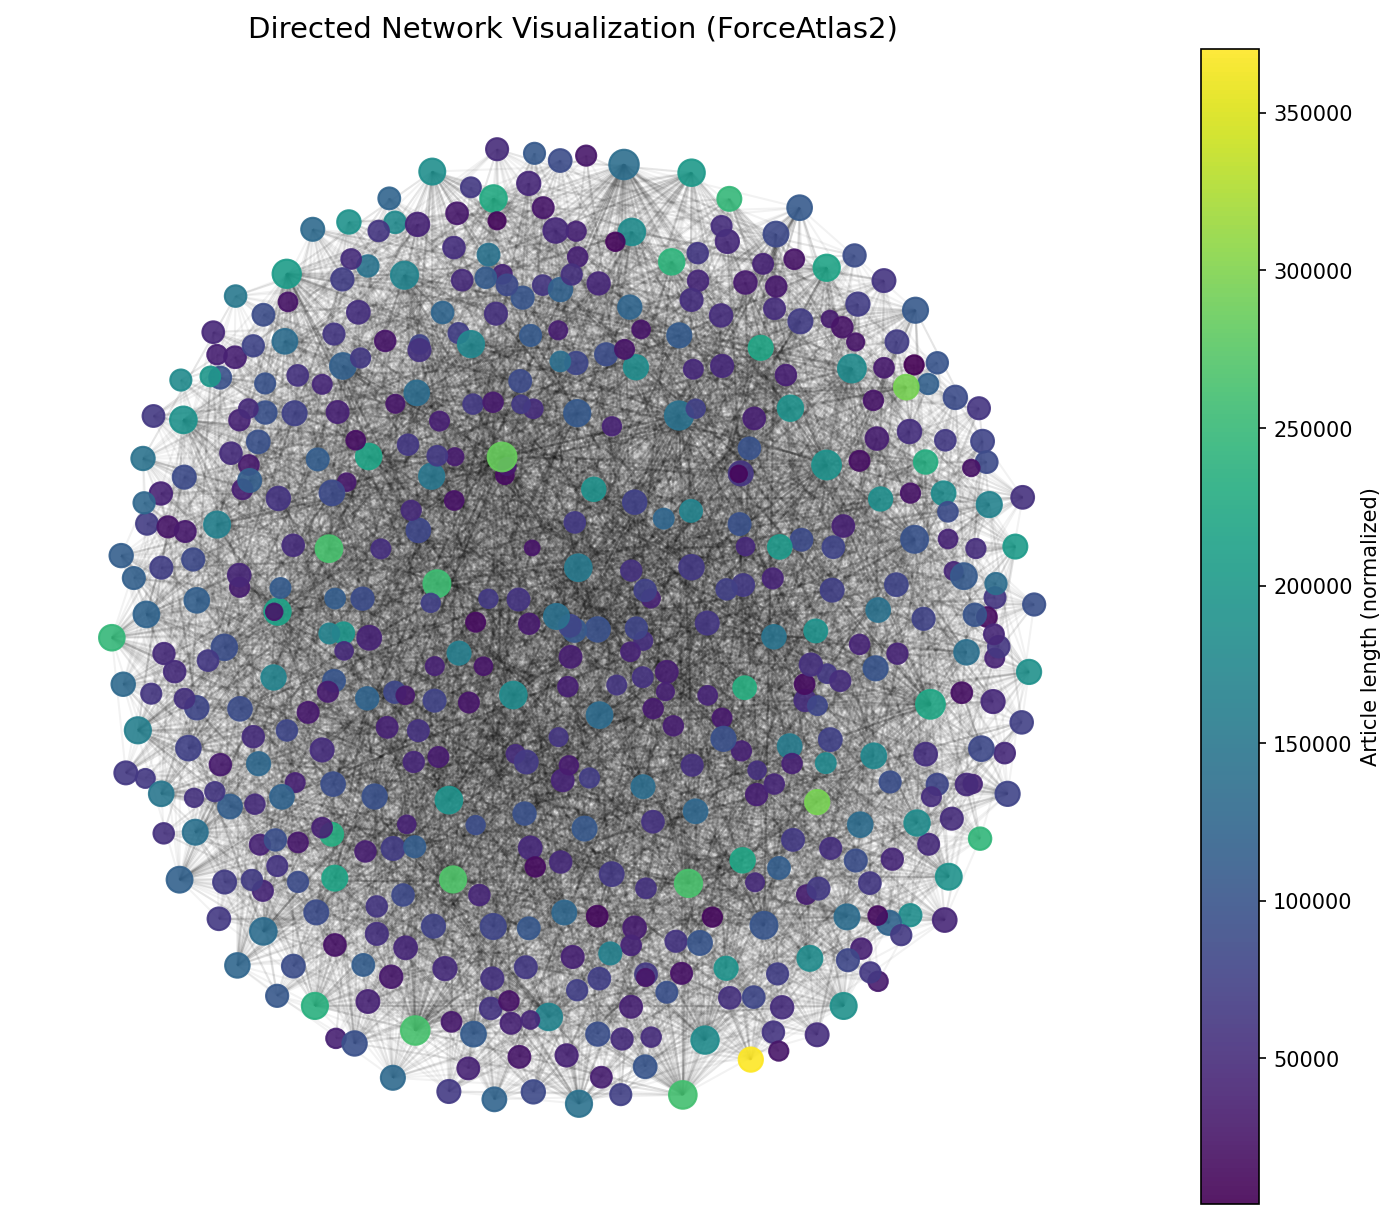

In [53]:
# Layout for visualization using ForceAtlas2
pos = nx.forceatlas2_layout(
    A,
    max_iter=800,
    scaling_ratio=8.0,
    gravity=0.3,
    linlog=True,
    dissuade_hubs=True,
    distributed_action=True,
    seed=42
)

# Prepare node attributes for visualization
lengths = np.array([A.nodes[n]["length_of_content"] for n in A.nodes()])
degrees = np.array([A.degree(n) for n in A.nodes()])   # total degree (in+out)

# Normalize node colors and sizes
node_color = [A.nodes[node]["length_of_content"] for node in A.nodes()]
node_size  = 50 + 150 * (degrees / degrees.max())**0.5   # gentle scaling

# Draw the network
plt.figure(figsize=(12, 10), dpi=150)
nx.draw_networkx_edges(A, pos, alpha=0.05, arrows=False)
nodes = nx.draw_networkx_nodes(
    A, pos,
    node_size=node_size,
    node_color=node_color,
    cmap=plt.cm.viridis,
    alpha=0.9
)

plt.axis("off")
plt.colorbar(nodes, label="Article length (normalized)")
plt.title("Directed Network Visualization (ForceAtlas2)", fontsize=14)
plt.show()

>The plot above provides a first impression of the artist reference network constructed from the Wikipedia articles. Each node represents an artist, and a directed edge indicates that one artist’s article mentions another.
>
>As you can see, the directed network is quite large and it's hard to draw any conclusions from this. However, this step just serves as a first means to gain a visualized overview of what we are dealing with. In the following steps, we will get into some metrics and find ways to achieve more meaningful visualizations...

### B) Basic Structure & Connectivity

>This step gives a quick overview of how the network is built: how big it is, how dense, and how connected the artists are.
We also check how often artists mention each other (reciprocity) and how tightly the network is grouped (clustering).

In [3]:
# Basic network stats
print("Number of nodes:", A.number_of_nodes())
print("Number of edges:", A.number_of_edges())
print("Density:", nx.density(A))

# Components
num_weak = nx.number_weakly_connected_components(A)
num_strong = nx.number_strongly_connected_components(A)
print("Weakly connected components:", num_weak)
print("Strongly connected components:", num_strong)

# Reciprocity (how many mutual links exist)
recip = nx.reciprocity(A)
print("Reciprocity:", round(recip, 3))

# Average clustering (convert to undirected first)
clust = nx.average_clustering(A.to_undirected())
print("Average clustering coefficient:", round(clust, 3))

# Size of the largest weakly connected component
largest_cc = max(nx.weakly_connected_components(A), key=len)
print("Largest weakly connected component size:", len(largest_cc),
      "nodes (", round(len(largest_cc)/A.number_of_nodes()*100, 2), "% )")

Number of nodes: 488
Number of edges: 7020
Density: 0.029538492611169084
Weakly connected components: 2
Strongly connected components: 50
Reciprocity: 0.343
Average clustering coefficient: 0.237
Largest weakly connected component size: 487 nodes ( 99.8 % )


>* The network contains 488 artists connected by 7,020 directed links, giving a low density (≈ 0.03), meaning only about 3 % of all possible artist-to-artist connections exist.
>* There are 2 weakly connected components, but the largest one already covers 99.8 % of all nodes, so the network is almost fully connected.
>* Inside this giant cluster, there are 50 strongly connected components, showing that some artists link back and forth, while others are only mentioned one way.
>
>* The reciprocity (0.34) means roughly one-third of links are mutual... a moderate level of two-way referencing.
>* The average clustering coefficient (0.24) suggests that small groups of artists often form tightly linked clusters, where artists tend to mention each other.

### C) Degree Distributions (in vs out)

>We now look at how links are distributed.
Because the graph is directed, we study in-degree (how often an artist is mentioned) and out-degree (how many others an artist mentions).
>We plot both on log–log scales and fit power-law models (Week 5), so we can see if a few artists dominate.

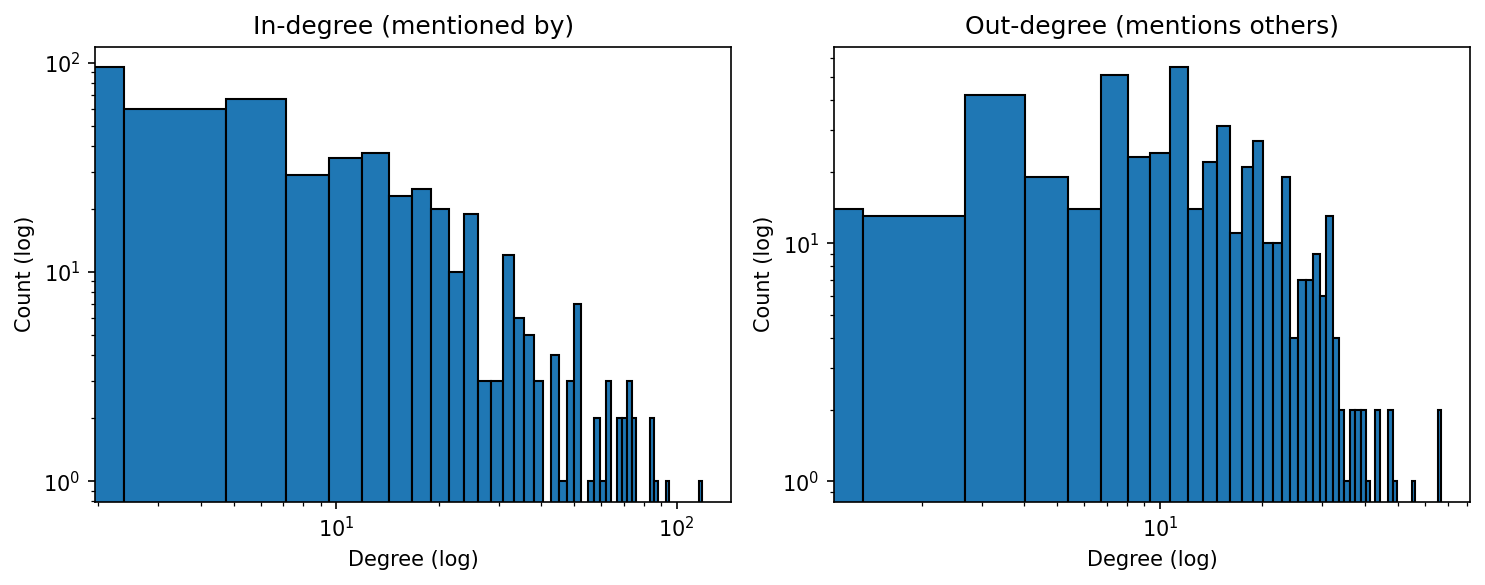

In [4]:
# Collect degrees (directed)
in_deg  = np.array([d for _, d in A.in_degree()])
out_deg = np.array([d for _, d in A.out_degree()])

# Simple log-log histograms
fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=150)

for data, title, ax in [(in_deg, "In-degree (mentioned by)", axs[0]),
                        (out_deg, "Out-degree (mentions others)", axs[1])]:
    ax.hist(data, bins=50, log=True, edgecolor="black")
    ax.set_xscale("log")
    ax.set_xlabel("Degree (log)")
    ax.set_ylabel("Count (log)")
    ax.set_title(title)

plt.tight_layout()
plt.show()


>Both plots show that the artist network has a heavy-tailed degree distribution.
Most artists have only a few links, while only a small number of artists have many.
>* The in-degree plot shows that only a few artists are mentioned frequently across Wikipedia pages.
>* The out-degree plot shows that only a few artists reference many others, while most link to very few.
>
>This pattern is typical for real-world social and information networks, where popularity and visibility are unevenly distributed.


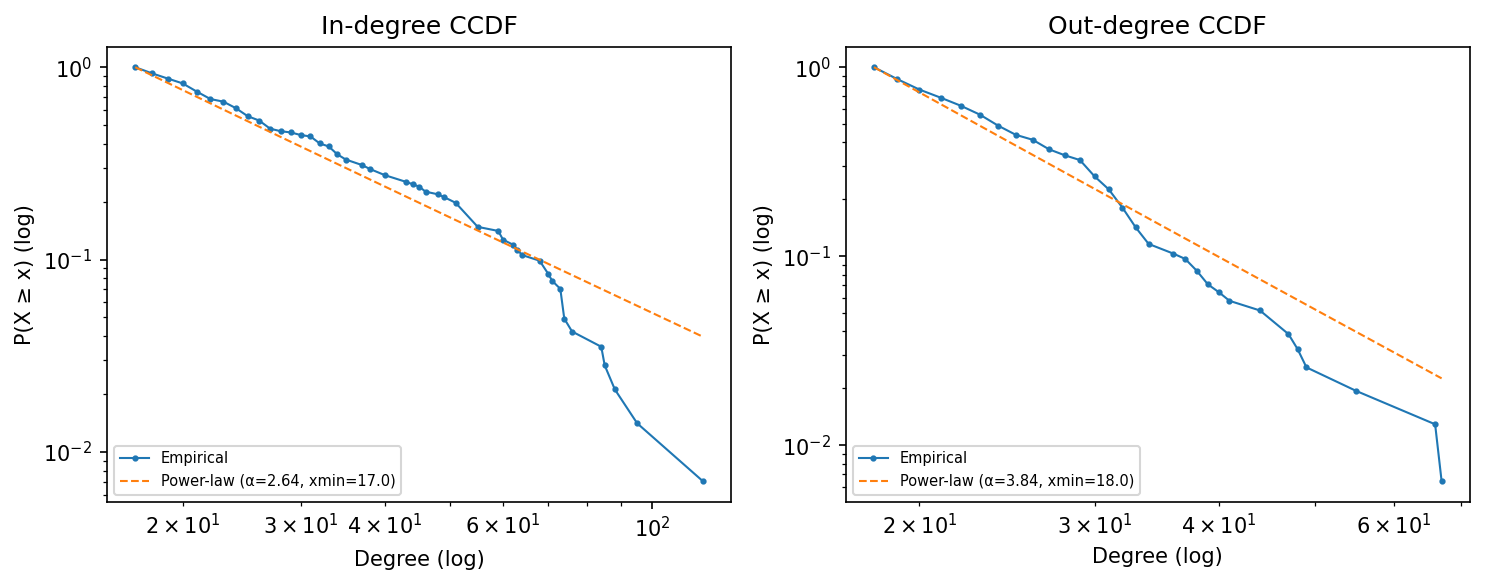

In [5]:
# CCDF + power-law fit 
import powerlaw

def ccdf_powerlaw_plot(data, ax, title):
    data = np.asarray(data)
    data = data[data >= 1] 
    fit = powerlaw.Fit(data, discrete=True, verbose=False)
    fit.plot_ccdf(ax=ax, label="Empirical", marker='o', markersize=2, linewidth=1)
    fit.power_law.plot_ccdf(ax=ax, linestyle='--', linewidth=1,
                            label=f"Power-law (α={fit.power_law.alpha:.2f}, xmin={fit.power_law.xmin})")
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("Degree (log)"); ax.set_ylabel("P(X ≥ x) (log)")
    ax.set_title(title); ax.legend(fontsize=7, loc="lower left")

fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=150)
ccdf_powerlaw_plot([d for _, d in A.in_degree()],  axs[0], "In-degree CCDF")
ccdf_powerlaw_plot([d for _, d in A.out_degree()], axs[1], "Out-degree CCDF")
plt.tight_layout(); 
plt.show()


>The power-law helps describe how connections are spread in networks; it shows whether many small values and only a few very large ones exist.
>
>Here, both plots follow that pattern: the tails of the curves drop slowly on a log–log scale, meaning that only a few artists have very high numbers of connections while most have very few.
>
>* In the in-degree plot, the flatter slope means a few artists are mentioned by many others.
>* In the out-degree plot, the steeper slope means only a small number of artists mention many others.
>
>Overall, this tells us the network is uneven but typical for real systems: a few highly visible artists dominate the structure, while most stay on the edges with few links.

### D) Centrality & Assortativity Analysis

>This section identifies the most important artists in the network and shows how they connect to each other.
We combine centrality measures (how “influential” or “bridging” an artist is) with mixing patterns (whether big artists connect to other big ones).

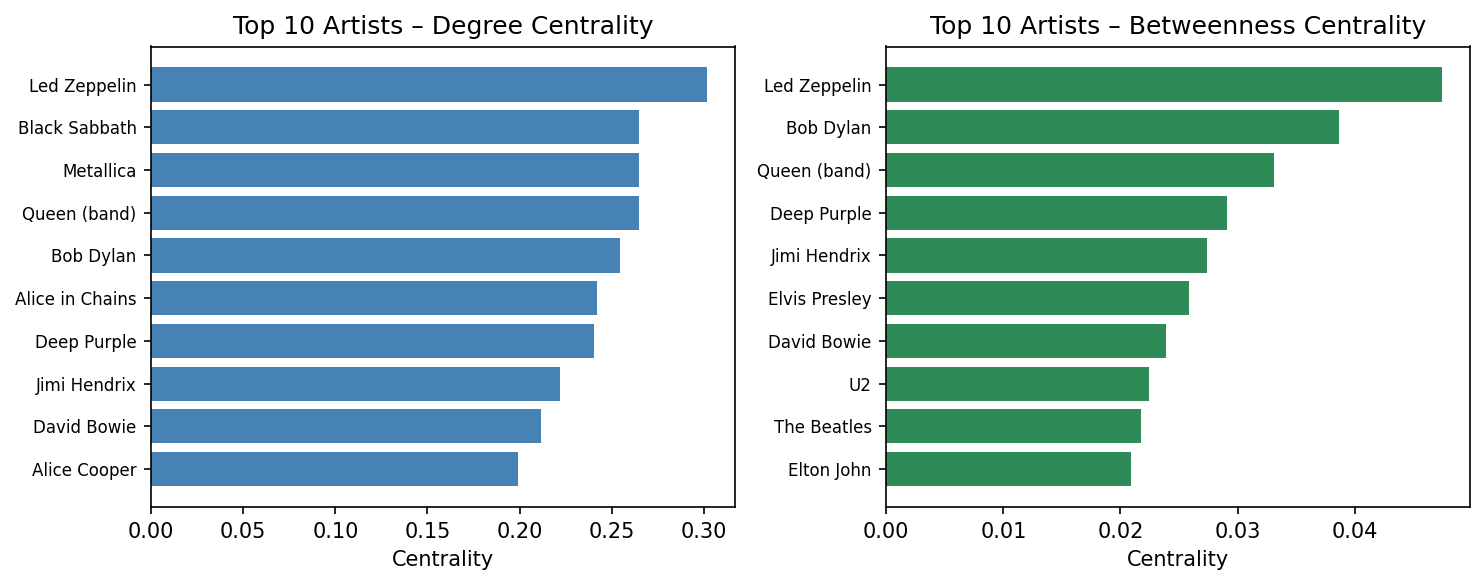

In [6]:
# Compute centralities
deg_cent = nx.degree_centrality(A)
bet_cent = nx.betweenness_centrality(A.to_undirected(), normalized=True)

# Top 10 for each
top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
top_bet = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:10]

# Convert to lists for plotting
deg_names, deg_values = zip(*top_deg)
bet_names, bet_values = zip(*top_bet)

# Side-by-side bar charts
fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=150)

axs[0].barh(deg_names[::-1], deg_values[::-1], color="steelblue")
axs[0].set_title("Top 10 Artists – Degree Centrality")
axs[0].set_xlabel("Centrality")
axs[0].tick_params(axis='y', labelsize=8)

axs[1].barh(bet_names[::-1], bet_values[::-1], color="seagreen")
axs[1].set_title("Top 10 Artists – Betweenness Centrality")
axs[1].set_xlabel("Centrality")
axs[1].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

>Both measures show different sides of importance in the artist network:
>
>* Degree centrality highlights artists that are widely connected — those who either mention many others or are mentioned often themselves. These artists form the most visible and well-linked hubs in the network.
>* Betweenness centrality points to artists who act as bridges between clusters or styles. They may not have the most links, but they connect otherwise distant parts of the network, helping information or influence flow between groups.
>
>Together, these metrics show that the network’s key figures are not only the most connected, but also those who link different communities within the music landscape.

>This next step checks whether artists with many links tend to connect to other well-connected artists, or if popular ones mostly connect to less connected ones. To do this, 'Assortativity' shows whether similar nodes connect, for example, if popular artists link to other popular ones.
>We also test if artists with longer Wikipedia pages (more detailed articles) tend to connect to others with similarly long pages. 

Degree assortativity coefficient: -0.009
Article-length assortativity coefficient: 0.058


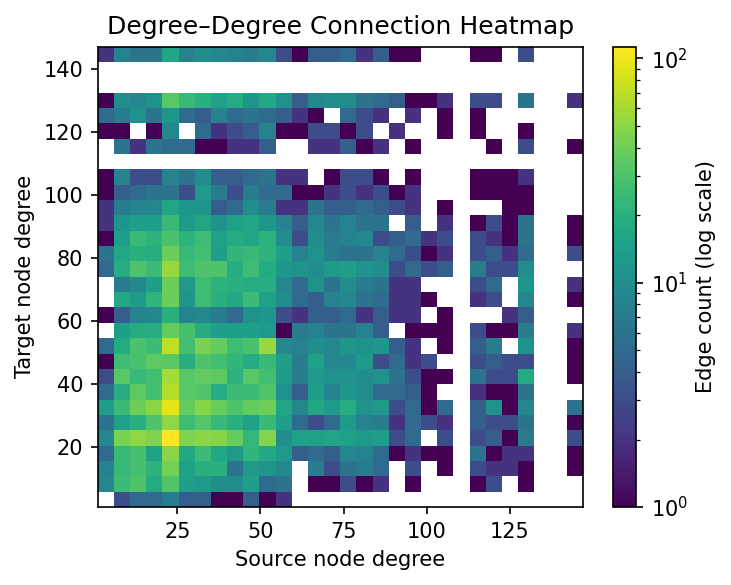

In [7]:
# Degree assortativity (using undirected version)
deg_assort = nx.degree_assortativity_coefficient(A.to_undirected())
print(f"Degree assortativity coefficient: {deg_assort:.3f}")

# Assortativity based on article length
lengths = nx.get_node_attributes(A, "length_of_content")
attr_assort = nx.numeric_assortativity_coefficient(A.to_undirected(), "length_of_content")
print(f"Article-length assortativity coefficient: {attr_assort:.3f}")

# Heatmap: degree of source vs degree of target
edges = np.array([(A.degree(u), A.degree(v)) for u, v in A.edges()])
x, y = edges[:, 0], edges[:, 1]

plt.figure(figsize=(5,4), dpi=150)
plt.hist2d(x, y, bins=30, cmap="viridis", norm="log")
plt.colorbar(label="Edge count (log scale)")
plt.xlabel("Source node degree")
plt.ylabel("Target node degree")
plt.title("Degree–Degree Connection Heatmap")
plt.tight_layout()
plt.show()

>Observations:
>* Degree assortativity (–0.01) → almost zero, meaning high- and low-degree artists mix freely.
>* Article-length assortativity (0.06) → weak, showing little connection preference by article size.
>
>In the heatmap, colors are spread without a clear diagonal, confirming that the network is not assortative. Connections form across different popularity levels rather than within tight groups.

### D) Network Visualization (Backbone)

>The full artist network is large and dense, which can make patterns hard to see.
>Here, we extract its backbone (the most tightly connected part) using a k-core.
>A k-core keeps only artists who have at least k links within this smaller subnetwork.
>This helps reveal the core structure and key connections between central artists.

Core size: 110 nodes, 1530 edges


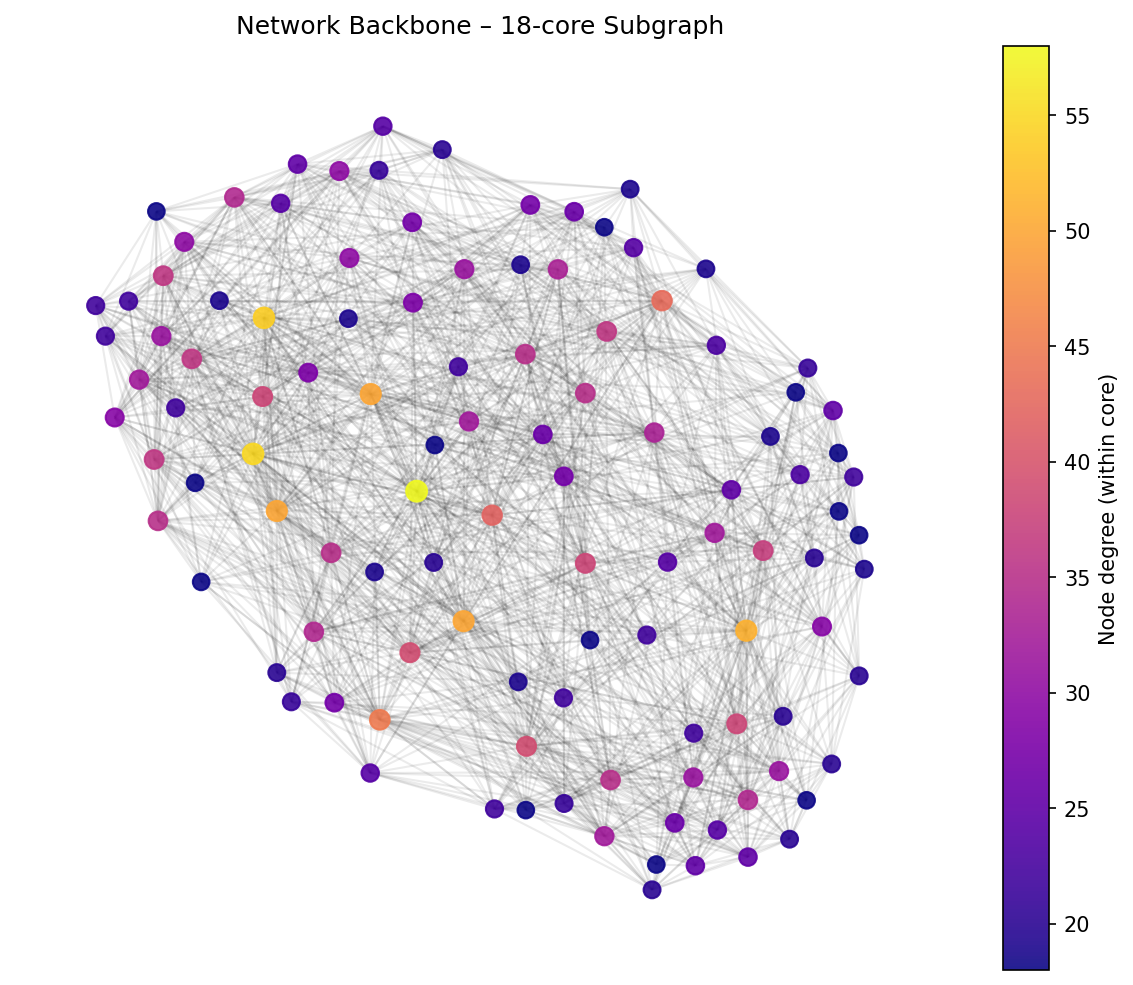

In [54]:
# Extract the 5-core (artists connected to ≥18 others within the subgraph)
core = nx.k_core(A.to_undirected(), k=18)
print("Core size:", core.number_of_nodes(), "nodes,", core.number_of_edges(), "edges")

# Prepare node attributes for visualization
deg_core = np.array([core.degree(n) for n in core.nodes()])
node_color = [core.degree(n) for n in core.nodes()]
node_size = 40 + 60 * (deg_core / deg_core.max())**0.8

# Layout and plot
pos_core = nx.forceatlas2_layout(
    core,                       # the graph
    max_iter=400,               # iterations
    scaling_ratio=7.0,         # scaling of attraction/ repulsion forces
    gravity=0.01,               # gravity (attraction to center)
    linlog=True,               # logarithmic attraction instead of linear
    dissuade_hubs=True,        # prevent them from attracting too many nodes
    distributed_action=False,   # distribute the attraction force evenly
    seed=42
)

plt.figure(figsize=(10,8), dpi=150)
nx.draw_networkx_edges(core, pos_core, alpha=0.08)
nodes = nx.draw_networkx_nodes(core, pos_core,
                               node_color=node_color, cmap="plasma",
                               node_size=node_size, alpha=0.9)
plt.colorbar(nodes, label="Node degree (within core)")
plt.title("Network Backbone – 18-core Subgraph", fontsize=12)
plt.axis("off")
plt.show()

>The 18-core shows only the most tightly connected part of the artist network. These are basically the “heavyweights” of the graph: the ones most referenced and most connected.

>#### Conclusion:
>The network behaves much like the music world itself.. most artists have few links, while a small group dominates. Degree distributions follow a power-law, showing a few hubs surrounded by many smaller nodes.
>Centrality measures revealed that some artists are popular, while others act as bridges between groups.